In [1]:
import pandas as pd
from tables import *
import numpy as np
from tqdm import tqdm_notebook as tqdm
import csv
from scipy import sparse
import pickle
import os

In [2]:
path = '/home/User1/data/self_citations/'

In [3]:
min_year = 1980
max_year = 2020
nb_years = max_year-min_year

In [4]:
disciplines = pd.read_csv(path+'liste_discipline.txt',encoding='latin_1',sep='\t')
list_disciplines = pd.unique(disciplines['EDiscipline'])
nb_disciplines = len(list_disciplines)

In [5]:
from matplotlib import pyplot as plt

In [6]:
types_cit = ['self','co','others']

In [7]:
authors_info = {}
with open(path+'model/authors_infos_model.csv','r') as f:
    reader = csv.reader(f,delimiter='\t')
    next(reader)
    for line in reader:
        authors_info[int(line[0])] = [line[1],int(line[2]),int(line[4]),int(line[3])]

In [8]:
#Map to auth ID
with open(path+'authors_disc.p','rb') as f:
    authors_disc_idx = pickle.load(f)

In [9]:
#Keys:idx,values:authorID
for disc in list_disciplines:
    authors_disc_idx[disc] = {authors_disc_idx[disc][x]:x for x in authors_disc_idx[disc]}

In [10]:
disc_groups = {'Arts and Humanities':['Arts','Humanities'],
              'Natural Sciences and Engineering':['Biology','Physics','Mathematics','Engineering and Technology','Earth and Space','Chemistry'],
              'Social Sciences':['Social Sciences','Psychology','Professional Fields','Health'],
             'Health Sciences':['Biomedical Research','Clinical Medicine']}

nb_groups = len(disc_groups)
group_names = list(disc_groups.keys())

### With network and condensed disc

In [ ]:
import pandas as pd

In [52]:
for i in tqdm(range(nb_groups)):
    group = group_names[i]   
    disc_group = disc_groups[group]
    arrays_refs = {}
    arrays_cits = {}
    nb_pubs = np.array([])
    for type_cit in types_cit:
        for disc in disc_group:
            load_ref = sparse.load_npz('{}/arrays/references_{}_{}_array_norm.npz'.format(path,type_cit,disc)).todense()
            load_cit = sparse.load_npz('{}/arrays/citations_{}_{}_array_norm.npz'.format(path,type_cit,disc)).todense()
            load_ref= np.sum(load_ref,axis=1)
            load_cit= np.sum(load_cit,axis=1)


            if type_cit in arrays_cits: 
                arrays_cits[type_cit] = np.concatenate([arrays_cits[type_cit],load_cit],axis=0)
                arrays_refs[type_cit] = np.concatenate([arrays_refs[type_cit],load_ref],axis=0)

            else:
                arrays_cits[type_cit] = load_cit
                arrays_refs[type_cit] = load_ref



    for disc in disc_group:
        load_ref = sparse.load_npz('{}/arrays/references_self_{}_network_array_norm.npz'.format(path,disc)).todense()
        load_cit = sparse.load_npz('{}/arrays/citations_self_{}_network_array_norm.npz'.format(path,disc)).todense()
        load_ref= np.sum(load_ref,axis=1)
        load_cit= np.sum(load_ref,axis=1)
        nb_auts = load_cit.shape[0]
        load_nb_pubs = np.array([authors_info[authors_disc_idx[disc][x]][2] for x in range(nb_auts)])
        if 'self_net' in arrays_cits:
            arrays_cits['self_net'] = np.concatenate([arrays_cits['self_net'],
                                                   load_cit],axis=0)
            arrays_refs['self_net'] = np.concatenate([arrays_refs['self_net'],
                                                   load_ref],axis=0)
            nb_pubs = np.concatenate([nb_pubs,load_nb_pubs],axis=0)
        else:
            arrays_cits['self_net'] = load_cit
            arrays_refs['self_net'] = load_ref
            nb_pubs = np.concatenate([nb_pubs,load_nb_pubs],axis=0)

    #arrays_cits['self_net'] = sparse.load_npz('{}/arrays/citations_self_{}_network_array_norm.npz'.format(path,disc)).todense()
    #arrays_refs['self_net'] = sparse.load_npz('{}/arrays/references_self_{}_network_array_norm.npz'.format(path,disc)).todense()
    total_refs = arrays_refs['self'] + arrays_refs['co'] + arrays_refs['others'] 
    total_cits =  arrays_cits['self'] + arrays_cits['co'] + arrays_cits['others'] 
    idx_cits = total_cits.nonzero()[0]
    idx_refs = total_refs.nonzero()[0]


    plot_types = ['self','co','self_net']
    stats_refs = {}
    stats_cits = {}
    nb_authors = len(nb_pubs)


    for type_cit in plot_types:
        arrays_refs[type_cit + '_perc'] = np.zeros(arrays_refs[type_cit].shape[0]) 
        arrays_cits[type_cit + '_perc'] = np.zeros(arrays_cits[type_cit].shape[0]) 

        arrays_refs[type_cit + '_perc'][idx_refs] = ((arrays_refs[type_cit][idx_refs]/total_refs[idx_refs])*100).ravel()
        arrays_cits[type_cit + '_perc'][idx_cits] = ((arrays_cits[type_cit][idx_cits]/total_cits[idx_cits])*100).ravel()

    li = []

    for aut_i in range(total_refs.shape[0]):
        li.append([arrays_cits[type_cit + '_perc'][aut_i] for type_cit in plot_types] +
                       [arrays_refs[type_cit + '_perc'][aut_i] for type_cit in plot_types] +
                       [nb_pubs[aut_i]])

    df = pd.DataFrame(li,columns=['self_cits','co_cits','self_net_cits','self_refs','co_refs','self_net_refs','nb_pubs'])


    stats = df.groupby('nb_pubs').agg({'self_cits':'mean','co_cits':'mean','self_net_cits':'mean',
                                       'self_refs':'mean','co_refs':'mean','self_net_refs':'mean'}).reset_index()
    stats = stats.loc[stats['nb_pubs']<=50]
    plt.figure(figsize=(15,6))
    plt.subplot(121)
    plt.plot(stats['nb_pubs'],stats['self_cits'],'r',label='% self citations',linewidth=2)
    plt.plot(stats['nb_pubs'],stats['co_cits'],'r--',label='% coauthors citations',linewidth=2)
    plt.plot(stats['nb_pubs'],stats['self_net_cits'],'r-.',label='% network citations',linewidth=2)
    plt.plot(stats['nb_pubs'],stats['self_refs'],'g',label='% self references',linewidth=2)
    plt.plot(stats['nb_pubs'],stats['co_refs'],'g--',label='% coauthors references',linewidth=2)
    plt.plot(stats['nb_pubs'],stats['self_net_refs'],'g-.',label='% network references',linewidth=2)
    plt.title(group,fontsize=20)
    plt.gca().set_ylim(bottom=0)
    plt.ylabel('%',fontsize=20)
    plt.xlabel('Publication #',fontsize=20)
    plt.legend()
    plt.tick_params(labelsize=18)


    plt.subplot(122)
    plt.plot(stats['nb_pubs'],stats['self_cits'] + stats['co_cits'] ,'b',label='% citations',linewidth=2)
    plt.plot(stats['nb_pubs'],stats['self_cits'] + stats['co_cits'] + stats['self_net_cits'],
             'b--',label='% citations w\\ network',linewidth=2)
    plt.plot(stats['nb_pubs'],stats['self_refs'] + stats['co_refs'] ,'orange',label = '% references',linewidth=2)
    plt.plot(stats['nb_pubs'],stats['self_refs'] + stats['co_refs'] + stats['self_net_refs'],
             color='orange',linestyle='--',label='% references w\\ network',linewidth=2)
    plt.title(group,fontsize=20)
    plt.gca().set_ylim(bottom=0)
    plt.ylabel('%',fontsize=20)
    plt.xlabel('Publication #',fontsize=20)
    plt.legend()
    plt.tick_params(labelsize=18)

    
    plt.legend()
    out_path = path+'results/perc_w_network_by_nb_arts/'.format(min_pubs)
    #plt.show()
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    plt.savefig(out_path + group + '.png')
    plt.savefig(out_path + group + '.svg')

    plt.close()
    del stats_refs, stats_cits,load_ref,load_cit,arrays_cits,arrays_refs

/home/User1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


A Jupyter Widget

### Show distributions and avg

bins_nb_pubs = [1,2,3,4,5,7,10,15,20,25,30,40,50,70,100,150,200,300,500,750,1000,1500,2000,2500,3000,4000]
nb_bins = len(bins_nb_pubs)
bins_lbl = bins_nb_pubs.copy()
bins_lbl[-6:] = ['1k','1.5k','2k','2.5k','3k','4k']

In [73]:
bins_nb_pubs = [1,2,3,4,5,7,10,15,20,25,30,40,50,75,100,200,300,500,750,999,4000]
nb_bins = len(bins_nb_pubs)
bins_lbl = bins_nb_pubs.copy()
bins_lbl[-1] = '1k+'

In [65]:
diff_pubs = np.diff(bins_nb_pubs)
labels = []
for i in range(nb_bins-1):
    diff = diff_pubs[i]-1
    bin_val = bins_nb_pubs[i]+1
    if diff == 0:
        labels.append(str(bin_val) + ' papers')
    else:
        labels.append('{}-{} papers'.format(str(bin_val),str(bin_val+diff)))
labels[-1] = '1k+ papers'

In [66]:
labels

['2 papers',
 '3 papers',
 '4 papers',
 '5 papers',
 '6-7 papers',
 '8-10 papers',
 '11-15 papers',
 '16-20 papers',
 '21-25 papers',
 '26-30 papers',
 '31-40 papers',
 '41-50 papers',
 '51-75 papers',
 '76-100 papers',
 '101-200 papers',
 '201-300 papers',
 '301-500 papers',
 '501-750 papers',
 '751-999 papers',
 '1k+ papers']

In [13]:
lim_y_label = {'Arts and Humanities':8,
              'Natural Sciences and Engineering':17,
              'Social Sciences':17,
             'Health Sciences':17}


In [14]:
import matplotlib.gridspec as gridspec
col_list = ['b','r','g']
title_list = ['Self','Coauthors','Collaborators']

#### Split subplots

In [79]:
for i in tqdm(range(nb_groups)):
    group = group_names[i]   
    disc_group = disc_groups[group]
    arrays_refs = {}
    arrays_cits = {}
    nb_pubs = np.array([])
    for type_cit in types_cit:
        for disc in disc_group:
            load_ref = sparse.load_npz('{}/arrays/references_{}_{}_array_norm.npz'.format(path,type_cit,disc)).todense()
            load_cit = sparse.load_npz('{}/arrays/citations_{}_{}_array_norm.npz'.format(path,type_cit,disc)).todense()
            load_ref= np.sum(load_ref,axis=1)
            load_cit= np.sum(load_cit,axis=1)


            if type_cit in arrays_cits: 
                arrays_cits[type_cit] = np.concatenate([arrays_cits[type_cit],load_cit],axis=0)
                arrays_refs[type_cit] = np.concatenate([arrays_refs[type_cit],load_ref],axis=0)

            else:
                arrays_cits[type_cit] = load_cit
                arrays_refs[type_cit] = load_ref



    for disc in disc_group:
        load_ref = sparse.load_npz('{}/arrays/references_self_{}_network_array_norm.npz'.format(path,disc)).todense()
        load_cit = sparse.load_npz('{}/arrays/citations_self_{}_network_array_norm.npz'.format(path,disc)).todense()
        load_ref= np.sum(load_ref,axis=1)
        load_cit= np.sum(load_cit,axis=1)
        nb_auts = load_cit.shape[0]
        load_nb_pubs = np.array([authors_info[authors_disc_idx[disc][x]][2] for x in range(nb_auts)])
        if 'self_net' in arrays_cits:
            arrays_cits['self_net'] = np.concatenate([arrays_cits['self_net'],
                                                   load_cit],axis=0)
            arrays_refs['self_net'] = np.concatenate([arrays_refs['self_net'],
                                                   load_ref],axis=0)
            nb_pubs = np.concatenate([nb_pubs,load_nb_pubs],axis=0)
        else:
            arrays_cits['self_net'] = load_cit
            arrays_refs['self_net'] = load_ref
            nb_pubs = np.concatenate([nb_pubs,load_nb_pubs],axis=0)

    #arrays_cits['self_net'] = sparse.load_npz('{}/arrays/citations_self_{}_network_array_norm.npz'.format(path,disc)).todense()
    #arrays_refs['self_net'] = sparse.load_npz('{}/arrays/references_self_{}_network_array_norm.npz'.format(path,disc)).todense()
    total_refs = arrays_refs['self'] + arrays_refs['co'] + arrays_refs['others'] 
    total_cits =  arrays_cits['self'] + arrays_cits['co'] + arrays_cits['others'] 
    idx_cits = total_cits.nonzero()[0]
    idx_refs = total_refs.nonzero()[0]


    plot_types = ['self','co','self_net']
    stats_refs = {}
    stats_cits = {}
    nb_authors = len(nb_pubs)


    for type_cit in plot_types:
        arrays_refs[type_cit + '_perc'] = np.zeros(arrays_refs[type_cit].shape[0]) 
        arrays_cits[type_cit + '_perc'] = np.zeros(arrays_cits[type_cit].shape[0]) 

        arrays_refs[type_cit + '_perc'][idx_refs] = ((arrays_refs[type_cit][idx_refs]/total_refs[idx_refs])*100).ravel()
        arrays_cits[type_cit + '_perc'][idx_cits] = ((arrays_cits[type_cit][idx_cits]/total_cits[idx_cits])*100).ravel()

    li = []

    for aut_i in range(total_refs.shape[0]):
        li.append([arrays_cits[type_cit + '_perc'][aut_i] for type_cit in plot_types] +
                       [arrays_refs[type_cit + '_perc'][aut_i] for type_cit in plot_types] +
                       [nb_pubs[aut_i]])

    df = pd.DataFrame(li,columns=['self_cits','co_cits','self_net_cits','self_refs','co_refs','self_net_refs','nb_pubs'])
    df = df.dropna()
    df['binned_pub'] = pd.cut(df['nb_pubs'],bins_nb_pubs)
    df['binned_pub'] = df['binned_pub'].apply(lambda x: int(x.right))
    fig = plt.figure(figsize=(33,33))
    outer = gridspec.GridSpec(5, 5, wspace=0.2, hspace=0.2)
    lim_lbl = lim_y_label[group]
    for bin_i in range(1,nb_bins):

        bin_val = bins_nb_pubs[bin_i]
        bin_lbl = labels[bin_i-1]
        df_hist = df.loc[df['binned_pub']==bin_val]


        kwargs = dict(alpha=0.7,range=(0,100),bins=20)


        inner = gridspec.GridSpecFromSubplotSpec(3, 1,
                        subplot_spec=outer[bin_i-1], wspace=0.1, hspace=0.1)

        for k in range(len(plot_types)):
            type_cit = plot_types[k]

            ax = plt.Subplot(fig, inner[k])
            ax.hist(df_hist[type_cit+'_cits'], **kwargs, color=col_list[k],label=title_list[k])
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            # Only show ticks on the left and bottom spines
            ax.yaxis.set_ticks_position('left')
            ax.xaxis.set_ticks_position('bottom')
            scale_y = 1e3
            y_vals = ax.get_yticks()
            if bin_i == 1:
                ax.legend()
            if bin_i < lim_lbl:
                ax.set_yticklabels(['{:d}'.format(int(x /scale_y)) for x in y_vals])
            if k == 0 :
                ax.set_title(bin_lbl,fontsize=18)
            if k == 1:
                if bin_i < lim_lbl:
                    ax.set_ylabel('Frequency (k)',fontsize=16)
                else:
                    ax.set_ylabel('Frequency',fontsize=16)
            #plt.tick_params(labelsize=8)
            if k ==2:
                ax.set_xlabel('% citations',fontsize=16)
            else:
                ax.tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off
            fig.add_subplot(ax)
    
  
    out_path = path+'results/perc_w_network_by_nb_arts/'
    #plt.show()
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    plt.savefig(out_path + group + '_hist.png')
    plt.savefig(out_path + group + '_hist.svg')

    plt.close()
    
    stats = df.groupby('binned_pub').agg({'self_cits':'mean','co_cits':'mean','self_net_cits':'mean',
                                       'self_refs':'mean','co_refs':'mean','self_net_refs':'mean'}).reset_index()
    
    plt.figure(figsize=(8,7.5))
    for k in range(2):
        ax = plt.subplot(2,1,k+1)
        if k == 0:
            max_art = 15
            s = 0
            e = np.where(np.array(bins_nb_pubs)==max_art)[0][0] 
            plt.title(group,fontsize=14)
        else:
            s = e
            e = nb_bins

            
        plt.plot(stats['binned_pub'][s:e],stats['self_cits'][s:e],'r',label='% direct citations',linewidth=3)
        plt.plot(stats['binned_pub'][s:e],stats['co_cits'][s:e],'r--',label='% coauthors citations',linewidth=3)
        plt.plot(stats['binned_pub'][s:e],stats['self_net_cits'][s:e],'r-.',label='% collaborators citations',linewidth=3)
        plt.plot(stats['binned_pub'][s:e],stats['self_refs'][s:e],'g',label='% direct references',linewidth=3)
        plt.plot(stats['binned_pub'][s:e],stats['co_refs'][s:e],'g--',label='% coauthors references',linewidth=3)
        plt.plot(stats['binned_pub'][s:e],stats['self_net_refs'][s:e],'g-.',label='% colaborators references',linewidth=3)

        plt.xticks(np.arange(nb_bins-1)[s:e],bins_lbl[1:][s:e])
        plt.ylabel('%',fontsize=12)
        plt.xlabel('# publications',fontsize=12)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        # Only show ticks on the left and bottom spines
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')

        plt.tick_params(labelsize=12)

    plt.legend()
    out_path = path+'results/perc_w_network_by_nb_arts/'
    #plt.show()
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    plt.savefig(out_path + group + '_full.png')
    plt.savefig(out_path + group + '_full.svg')
    plt.close()
    
    
    
    
    
    del stats_refs, stats_cits,load_ref,load_cit,arrays_cits,arrays_refs
    
    
    

/home/User1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


A Jupyter Widget

#### No split

In [55]:
from matplotlib.ticker import PercentFormatter

In [77]:
for i in tqdm(range(nb_groups)):
    group = group_names[i]   
    disc_group = disc_groups[group]
    arrays_refs = {}
    arrays_cits = {}
    nb_pubs = np.array([])
    for type_cit in types_cit:
        for disc in disc_group:
            load_ref = sparse.load_npz('{}/arrays/references_{}_{}_array_norm.npz'.format(path,type_cit,disc)).todense()
            load_cit = sparse.load_npz('{}/arrays/citations_{}_{}_array_norm.npz'.format(path,type_cit,disc)).todense()
            load_ref= np.sum(load_ref,axis=1)
            load_cit= np.sum(load_cit,axis=1)


            if type_cit in arrays_cits: 
                arrays_cits[type_cit] = np.concatenate([arrays_cits[type_cit],load_cit],axis=0)
                arrays_refs[type_cit] = np.concatenate([arrays_refs[type_cit],load_ref],axis=0)

            else:
                arrays_cits[type_cit] = load_cit
                arrays_refs[type_cit] = load_ref



    for disc in disc_group:
        load_ref = sparse.load_npz('{}/arrays/references_self_{}_network_array_norm.npz'.format(path,disc)).todense()
        load_cit = sparse.load_npz('{}/arrays/citations_self_{}_network_array_norm.npz'.format(path,disc)).todense()
        load_ref= np.sum(load_ref,axis=1)
        load_cit= np.sum(load_cit,axis=1)
        nb_auts = load_cit.shape[0]
        load_nb_pubs = np.array([authors_info[authors_disc_idx[disc][x]][2] for x in range(nb_auts)])
        if 'self_net' in arrays_cits:
            arrays_cits['self_net'] = np.concatenate([arrays_cits['self_net'],
                                                   load_cit],axis=0)
            arrays_refs['self_net'] = np.concatenate([arrays_refs['self_net'],
                                                   load_ref],axis=0)
            nb_pubs = np.concatenate([nb_pubs,load_nb_pubs],axis=0)
        else:
            arrays_cits['self_net'] = load_cit
            arrays_refs['self_net'] = load_ref
            nb_pubs = np.concatenate([nb_pubs,load_nb_pubs],axis=0)

    #arrays_cits['self_net'] = sparse.load_npz('{}/arrays/citations_self_{}_network_array_norm.npz'.format(path,disc)).todense()
    #arrays_refs['self_net'] = sparse.load_npz('{}/arrays/references_self_{}_network_array_norm.npz'.format(path,disc)).todense()
    total_refs = arrays_refs['self'] + arrays_refs['co'] + arrays_refs['others'] 
    total_cits =  arrays_cits['self'] + arrays_cits['co'] + arrays_cits['others'] 
    idx_cits = total_cits.nonzero()[0]
    idx_refs = total_refs.nonzero()[0]


    plot_types = ['self','co','self_net']
    stats_refs = {}
    stats_cits = {}
    nb_authors = len(nb_pubs)


    for type_cit in plot_types:
        arrays_refs[type_cit + '_perc'] = np.zeros(arrays_refs[type_cit].shape[0]) 
        arrays_cits[type_cit + '_perc'] = np.zeros(arrays_cits[type_cit].shape[0]) 

        arrays_refs[type_cit + '_perc'][idx_refs] = ((arrays_refs[type_cit][idx_refs]/total_refs[idx_refs])*100).ravel()
        arrays_cits[type_cit + '_perc'][idx_cits] = ((arrays_cits[type_cit][idx_cits]/total_cits[idx_cits])*100).ravel()

    li = []

    for aut_i in range(total_refs.shape[0]):
        li.append([arrays_cits[type_cit + '_perc'][aut_i] for type_cit in plot_types] +
                       [arrays_refs[type_cit + '_perc'][aut_i] for type_cit in plot_types] +
                       [nb_pubs[aut_i]])

    df = pd.DataFrame(li,columns=['self_cits','co_cits','self_net_cits','self_refs','co_refs','self_net_refs','nb_pubs'])
    df = df.dropna()
    df['binned_pub'] = pd.cut(df['nb_pubs'],bins_nb_pubs)
    df['binned_pub'] = df['binned_pub'].apply(lambda x: int(x.right))
    fig = plt.figure(figsize=(33,25))
    outer = gridspec.GridSpec(4, 5, wspace=0.2, hspace=0.2)
    lim_lbl = lim_y_label[group]
    for bin_i in range(1,nb_bins):

        bin_val = bins_nb_pubs[bin_i]
        bin_lbl = labels[bin_i-1]
        df_hist = df.loc[df['binned_pub']==bin_val]


        kwargs = dict(alpha=0.7,range=(0,100),bins=20)

        inner = gridspec.GridSpecFromSubplotSpec(3, 1,
                            subplot_spec=outer[bin_i-1], wspace=0.1, hspace=0.1)
        for k in range(len(plot_types)):
            type_cit = plot_types[k]

            ax = plt.Subplot(fig, inner[k])
            ax.hist(df_hist[type_cit+'_cits'], **kwargs, color=col_list[k],label=title_list[k],
                    weights=np.ones(len(df_hist[type_cit+'_cits'])) / len(df_hist[type_cit+'_cits']))
            plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            # Only show ticks on the left and bottom spines
            ax.yaxis.set_ticks_position('left')
            ax.xaxis.set_ticks_position('bottom')
            plt.tick_params(labelsize=11)
            scale_y = 1e3
            y_vals = ax.get_yticks()
            if bin_i == 1:
                ax.legend()
            if bin_i < lim_lbl:
                ax.set_yticklabels(['{:d}'.format(int(x /scale_y)) for x in y_vals])
            if k == 0 :
                ax.set_title(bin_lbl,fontsize=18)

            if k ==2:
                ax.set_xlabel('% citations',fontsize=16)
            else:
                ax.tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off
            fig.add_subplot(ax)
  
    out_path = path+'results/perc_w_network_by_nb_arts/'
    #plt.show()
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    plt.savefig(out_path + group + '_hist_perc.png')
    plt.savefig(out_path + group + '_hist_perc.svg')

    plt.close()
    
    stats = df.groupby('binned_pub').agg({'self_cits':'mean','co_cits':'mean','self_net_cits':'mean',
                                       'self_refs':'mean','co_refs':'mean','self_net_refs':'mean'}).reset_index()
    
    plt.figure(figsize=(12,3.75))

    plt.plot(stats['binned_pub'],stats['self_cits'],'r',label='% direct citations',linewidth=3)
    plt.plot(stats['binned_pub'],stats['co_cits'],'r--',label='% coauthors citations',linewidth=3)
    plt.plot(stats['binned_pub'],stats['self_net_cits'],'r-.',label='% collaborators citations',linewidth=3)
    plt.plot(stats['binned_pub'],stats['self_refs'],'g',label='% direct references',linewidth=3)
    plt.plot(stats['binned_pub'],stats['co_refs'],'g--',label='% coauthors references',linewidth=3)
    plt.plot(stats['binned_pub'],stats['self_net_refs'],'g-.',label='% colaborators references',linewidth=3)

    plt.xticks(np.arange(nb_bins-1),bins_lbl[1:])
    plt.ylabel('%',fontsize=12)
    plt.xlabel('# publications',fontsize=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    plt.title(group,fontsize=15)
    plt.tick_params(labelsize=12)

    plt.legend()

    plt.legend()
    out_path = path+'results/perc_w_network_by_nb_arts/'
    #plt.show()
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    plt.savefig(out_path + group + '_full_long.png')
    plt.savefig(out_path + group + '_full_long.svg')
    plt.close()
    
    
    
    
    
    del stats_refs, stats_cits,load_ref,load_cit,arrays_cits,arrays_refs
    

/home/User1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


A Jupyter Widget

### Log-log scale

In [11]:
for i in tqdm(range(nb_groups)):
    group = group_names[i]   
    disc_group = disc_groups[group]
    arrays_refs = {}
    arrays_cits = {}
    nb_pubs = np.array([])
    for type_cit in types_cit:
        for disc in disc_group:
            load_ref = sparse.load_npz('{}/arrays/references_{}_{}_array_norm.npz'.format(path,type_cit,disc)).todense()
            load_cit = sparse.load_npz('{}/arrays/citations_{}_{}_array_norm.npz'.format(path,type_cit,disc)).todense()
            load_ref= np.sum(load_ref,axis=1)
            load_cit= np.sum(load_cit,axis=1)


            if type_cit in arrays_cits: 
                arrays_cits[type_cit] = np.concatenate([arrays_cits[type_cit],load_cit],axis=0)
                arrays_refs[type_cit] = np.concatenate([arrays_refs[type_cit],load_ref],axis=0)

            else:
                arrays_cits[type_cit] = load_cit
                arrays_refs[type_cit] = load_ref



    for disc in disc_group:
        load_ref = sparse.load_npz('{}/arrays/references_self_{}_network_array_norm.npz'.format(path,disc)).todense()
        load_cit = sparse.load_npz('{}/arrays/citations_self_{}_network_array_norm.npz'.format(path,disc)).todense()
        load_ref= np.sum(load_ref,axis=1)
        load_cit= np.sum(load_cit,axis=1)
        nb_auts = load_cit.shape[0]
        load_nb_pubs = np.array([authors_info[authors_disc_idx[disc][x]][2] for x in range(nb_auts)])
        if 'self_net' in arrays_cits:
            arrays_cits['self_net'] = np.concatenate([arrays_cits['self_net'],
                                                   load_cit],axis=0)
            arrays_refs['self_net'] = np.concatenate([arrays_refs['self_net'],
                                                   load_ref],axis=0)
            nb_pubs = np.concatenate([nb_pubs,load_nb_pubs],axis=0)
        else:
            arrays_cits['self_net'] = load_cit
            arrays_refs['self_net'] = load_ref
            nb_pubs = np.concatenate([nb_pubs,load_nb_pubs],axis=0)

    #arrays_cits['self_net'] = sparse.load_npz('{}/arrays/citations_self_{}_network_array_norm.npz'.format(path,disc)).todense()
    #arrays_refs['self_net'] = sparse.load_npz('{}/arrays/references_self_{}_network_array_norm.npz'.format(path,disc)).todense()
    total_refs = arrays_refs['self'] + arrays_refs['co'] + arrays_refs['others'] 
    total_cits =  arrays_cits['self'] + arrays_cits['co'] + arrays_cits['others'] 
    idx_cits = total_cits.nonzero()[0]
    idx_refs = total_refs.nonzero()[0]


    plot_types = ['self','co','self_net']
    stats_refs = {}
    stats_cits = {}
    nb_authors = len(nb_pubs)


    for type_cit in plot_types:
        arrays_refs[type_cit + '_perc'] = np.zeros(arrays_refs[type_cit].shape[0]) 
        arrays_cits[type_cit + '_perc'] = np.zeros(arrays_cits[type_cit].shape[0]) 

        arrays_refs[type_cit + '_perc'][idx_refs] = ((arrays_refs[type_cit][idx_refs]/total_refs[idx_refs])*100).ravel()
        arrays_cits[type_cit + '_perc'][idx_cits] = ((arrays_cits[type_cit][idx_cits]/total_cits[idx_cits])*100).ravel()

    li = []

    for aut_i in range(total_refs.shape[0]):
        li.append([arrays_cits[type_cit + '_perc'][aut_i] for type_cit in plot_types] +
                       [arrays_refs[type_cit + '_perc'][aut_i] for type_cit in plot_types] +
                       [nb_pubs[aut_i]])

    df = pd.DataFrame(li,columns=['self_cits','co_cits','self_net_cits','self_refs','co_refs','self_net_refs','nb_pubs'])
    df = df.dropna()

    
    stats = df.groupby('nb_pubs').agg({'self_cits':'mean','co_cits':'mean','self_net_cits':'mean',
                                       'self_refs':'mean','co_refs':'mean','self_net_refs':'mean'}).reset_index()
    
    plt.figure(figsize=(7,3.75))
    ax = plt.axes()
    plt.plot(stats['nb_pubs'],stats['self_cits'],'r',label='% direct citations',linewidth=3)
    plt.plot(stats['nb_pubs'],stats['co_cits'],'r--',label='% coauthors citations',linewidth=3)
    plt.plot(stats['nb_pubs'],stats['self_net_cits'],'r-.',label='% collaborators citations',linewidth=3)
    plt.plot(stats['nb_pubs'],stats['self_refs'],'g',label='% direct references',linewidth=3)
    plt.plot(stats['nb_pubs'],stats['co_refs'],'g--',label='% coauthors references',linewidth=3)
    plt.plot(stats['nb_pubs'],stats['self_net_refs'],'g-.',label='% colaborators references',linewidth=3)

    ax.set_xscale('log')
    plt.ylabel('%',fontsize=12)
    plt.xlabel('# publications',fontsize=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    plt.title(group,fontsize=15)
    plt.tick_params(labelsize=12)


    plt.legend()
    out_path = path+'results/perc_w_network_by_nb_arts/'
    #plt.show()
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    plt.savefig(out_path + group + '_full_log.png')
    plt.savefig(out_path + group + '_full_log.svg')
    plt.close()
    

    del stats_refs, stats_cits,load_ref,load_cit,arrays_cits,arrays_refs

/home/User1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


A Jupyter Widget

In [12]:
group = group_names[0]   
disc_group = disc_groups[group]
arrays_refs = {}
arrays_cits = {}
nb_pubs = np.array([])
for type_cit in types_cit:
    for disc in disc_group:
        load_ref = sparse.load_npz('{}/arrays/references_{}_{}_array_norm.npz'.format(path,type_cit,disc)).todense()
        load_cit = sparse.load_npz('{}/arrays/citations_{}_{}_array_norm.npz'.format(path,type_cit,disc)).todense()
        load_ref= np.sum(load_ref,axis=1)
        load_cit= np.sum(load_cit,axis=1)


        if type_cit in arrays_cits: 
            arrays_cits[type_cit] = np.concatenate([arrays_cits[type_cit],load_cit],axis=0)
            arrays_refs[type_cit] = np.concatenate([arrays_refs[type_cit],load_ref],axis=0)

        else:
            arrays_cits[type_cit] = load_cit
            arrays_refs[type_cit] = load_ref



for disc in disc_group:
    load_ref = sparse.load_npz('{}/arrays/references_self_{}_network_array_norm.npz'.format(path,disc)).todense()
    load_cit = sparse.load_npz('{}/arrays/citations_self_{}_network_array_norm.npz'.format(path,disc)).todense()
    load_ref= np.sum(load_ref,axis=1)
    load_cit= np.sum(load_cit,axis=1)
    nb_auts = load_cit.shape[0]
    load_nb_pubs = np.array([authors_info[authors_disc_idx[disc][x]][2] for x in range(nb_auts)])
    if 'self_net' in arrays_cits:
        arrays_cits['self_net'] = np.concatenate([arrays_cits['self_net'],
                                               load_cit],axis=0)
        arrays_refs['self_net'] = np.concatenate([arrays_refs['self_net'],
                                               load_ref],axis=0)
        nb_pubs = np.concatenate([nb_pubs,load_nb_pubs],axis=0)
    else:
        arrays_cits['self_net'] = load_cit
        arrays_refs['self_net'] = load_ref
        nb_pubs = np.concatenate([nb_pubs,load_nb_pubs],axis=0)

#arrays_cits['self_net'] = sparse.load_npz('{}/arrays/citations_self_{}_network_array_norm.npz'.format(path,disc)).todense()
#arrays_refs['self_net'] = sparse.load_npz('{}/arrays/references_self_{}_network_array_norm.npz'.format(path,disc)).todense()
total_refs = arrays_refs['self'] + arrays_refs['co'] + arrays_refs['others'] 
total_cits =  arrays_cits['self'] + arrays_cits['co'] + arrays_cits['others'] 
idx_cits = total_cits.nonzero()[0]
idx_refs = total_refs.nonzero()[0]


plot_types = ['self','co','self_net']
stats_refs = {}
stats_cits = {}
nb_authors = len(nb_pubs)


for type_cit in plot_types:
    arrays_refs[type_cit + '_perc'] = np.zeros(arrays_refs[type_cit].shape[0]) 
    arrays_cits[type_cit + '_perc'] = np.zeros(arrays_cits[type_cit].shape[0]) 

    arrays_refs[type_cit + '_perc'][idx_refs] = ((arrays_refs[type_cit][idx_refs]/total_refs[idx_refs])*100).ravel()
    arrays_cits[type_cit + '_perc'][idx_cits] = ((arrays_cits[type_cit][idx_cits]/total_cits[idx_cits])*100).ravel()

li = []

for aut_i in range(total_refs.shape[0]):
    li.append([arrays_cits[type_cit + '_perc'][aut_i] for type_cit in plot_types] +
                   [arrays_refs[type_cit + '_perc'][aut_i] for type_cit in plot_types] +
                   [nb_pubs[aut_i]])

df = pd.DataFrame(li,columns=['self_cits','co_cits','self_net_cits','self_refs','co_refs','self_net_refs','nb_pubs'])
df = df.dropna()


stats = df.groupby('nb_pubs').agg({'self_cits':'mean','co_cits':'mean','self_net_cits':'mean',
                                   'self_refs':'mean','co_refs':'mean','self_net_refs':'mean'}).reset_index()


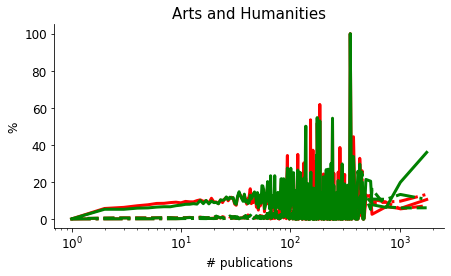

In [14]:

plt.figure(figsize=(7,3.75))
ax = plt.axes()
plt.plot(stats['nb_pubs'],stats['self_cits'],'r',label='% direct citations',linewidth=3)
plt.plot(stats['nb_pubs'],stats['co_cits'],'r--',label='% coauthors citations',linewidth=3)
plt.plot(stats['nb_pubs'],stats['self_net_cits'],'r-.',label='% collaborators citations',linewidth=3)
plt.plot(stats['nb_pubs'],stats['self_refs'],'g',label='% direct references',linewidth=3)
plt.plot(stats['nb_pubs'],stats['co_refs'],'g--',label='% coauthors references',linewidth=3)
plt.plot(stats['nb_pubs'],stats['self_net_refs'],'g-.',label='% colaborators references',linewidth=3)

ax.set_xscale('log')
plt.ylabel('%',fontsize=12)
plt.xlabel('# publications',fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.title(group,fontsize=15)
plt.tick_params(labelsize=12)
plt.show()